# Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import glob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import multiprocessing as mp
import cv2
from scipy.signal import resample
import wave
from sklearn.model_selection import train_test_split

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

import variables as var

In [6]:
# var.TO_PATH = "/content/drive/MyDrive/Thesis/PREP/sub_data"

In [7]:
# prep_df = pd.read_csv("/content/drive/MyDrive/Thesis/PREP/prepped_df.csv")
prep_df = pd.read_csv("prepped_df.csv")
prep_df

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Set,ECR,NAWP
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,train,0.000000,0.000000
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,train,0.000000,0.000000
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,train,0.000000,0.000000
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,train,0.000000,0.000000
4,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,train,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
57833,58ec27987a35909f4006f136118c6940,21.033333,34494,131030,sportscommentator voiceover,NaN,test,0.269961,0.999466
57834,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 Years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,test,0.371187,0.999596
57835,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,test,0.275392,0.999893
57836,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,test,0.012459,0.999924


In [8]:
def find_matching_ids(directory):
    npz_ids = set()
    wav_ids = set()

    for file in os.listdir(directory):
        if file.endswith(".npz"):
            npz_ids.add(file[:-4])  # Remove .npz
        elif file.endswith(".wav"):
            wav_ids.add(file[:-4])  # Remove .wav

    common_ids = npz_ids & wav_ids  # Find IDs present in both sets
    return sorted(common_ids)

existed_ids_train = find_matching_ids(var.TO_PATH + "/train")
existed_ids_test = find_matching_ids(var.TO_PATH + "/test")

prep_df = prep_df[prep_df["Id"].isin(existed_ids_train) | prep_df["Id"].isin(existed_ids_test)]
prep_df = prep_df.reset_index(drop=True)
len(prep_df)

0

In [9]:
prep_df.sample(10)

ValueError: a must be greater than 0 unless no samples are taken

# Check distribution

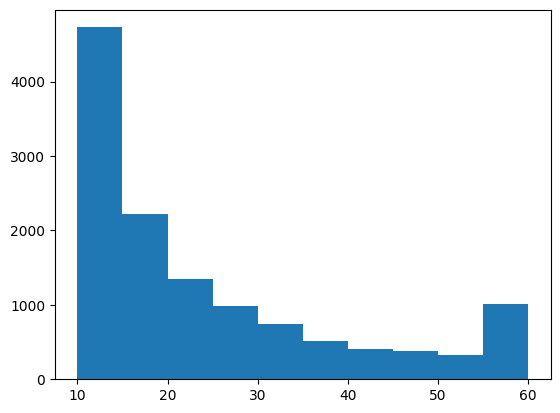

In [ ]:
plt.hist(prep_df['Video_len'])
plt.show()

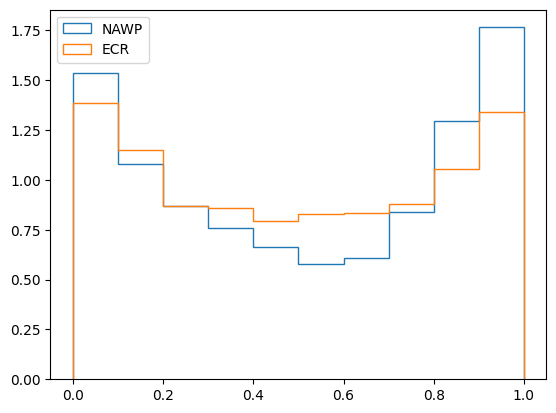

In [ ]:
plt.hist(prep_df['NAWP'], density=True, histtype='step', label='NAWP')
plt.hist(prep_df['ECR'], density=True, histtype='step', label='ECR')
plt.legend()
plt.show()

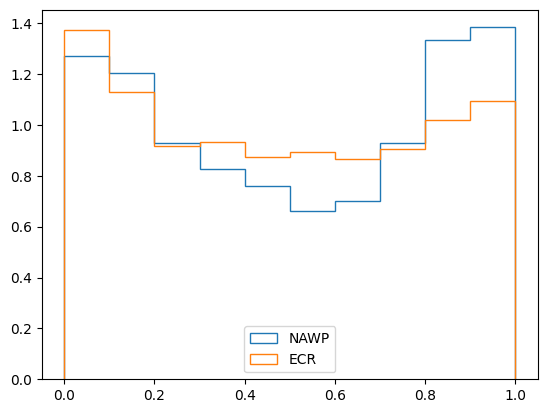

In [ ]:
plt.hist(prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]['NAWP'], density=True, histtype='step', label='NAWP')
plt.hist(prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]['ECR'], density=True, histtype='step', label='ECR')
plt.legend()
plt.show()

In [ ]:
prep_df = prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]

In [ ]:
prep_df['NAWP'].min(), prep_df['NAWP'].max(), prep_df['ECR'].min(), prep_df['ECR'].max()

(np.float64(0.0),
 np.float64(0.9999771167048056),
 np.float64(0.0),
 np.float64(1.0))

# Filter data

# Load data

In [ ]:
prep_df.sample(1)['Set'].values[0]

'train'

Sample ID: 577f0d3b19d7ada4b044138789063c26
Loaded Video Shape: (50, 224, 128, 3)
Loaded Audio Shape: (166441,)


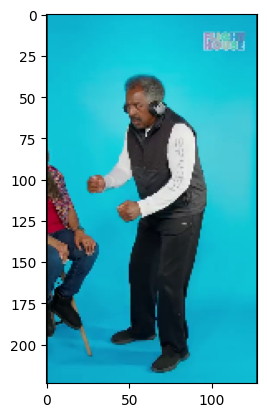

In [ ]:
def load_video_audio(video_file, audio_file):
    video_data = np.load(video_file)
    video_array = video_data["video"]

    with wave.open(audio_file, 'r') as wf:
        sample_rate = wf.getframerate()
        audio_array = np.frombuffer(wf.readframes(wf.getnframes()), dtype=np.int16)

    return video_array, audio_array

sample = prep_df.sample(1)
print(f"Sample ID: {sample['Id'].values[0]}")

video_loaded, audio_loaded = load_video_audio(video_file=f"{var.TO_PATH}/{sample['Set'].values[0]}/{sample['Id'].values[0]}.npz",
                                                         audio_file=f"{var.TO_PATH}/{sample['Set'].values[0]}/{sample['Id'].values[0]}.wav")
print(f"Loaded Video Shape: {video_loaded.shape}")  # (num_frames, height, width, 3)
print(f"Loaded Audio Shape: {audio_loaded.shape}")

plt.imshow(video_loaded[0])
plt.show()

# Create dataset

In [ ]:
import torch
import numpy as np
import wave
import os

class VideoAudioDataset(torch.utils.data.Dataset):
    def __init__(self, df, prep_path):
        self.prep_path = prep_path
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        sample_id = sample["Id"]
        label = [sample["ECR"], sample["NAWP"]]

        video_path = f"{self.prep_path}/{self.df.iloc[idx]['Set']}/{sample_id}.npz"
        audio_path = f"{self.prep_path}/{self.df.iloc[idx]['Set']}/{sample_id}.wav"

        video_array, audio_array = load_video_audio(video_path, audio_path)

        # Convert to tensors
        video_tensor = torch.tensor(video_array, dtype=torch.float32)
        audio_tensor = torch.tensor(audio_array, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32)

        return {
            "id": sample_id,
            "video": video_tensor,
            "audio": audio_tensor,
            "label": label_tensor
        }

def collate_fn(batch, max_frames, max_audio_samples):
    """Custom collate function to pad frames and audio."""

    video_tensors = []
    audio_tensors = []
    labels = []
    ids = []
    sample_rates = []

    for sample in batch:
        video = sample["video"]
        audio = sample["audio"]
        num_frames = video.shape[0]
        num_audio_samples = audio.shape[0]

        # Pad video to 300 frames
        if num_frames < max_frames:
            pad_frames = max_frames - num_frames
            padded_video = torch.cat([video, torch.zeros((pad_frames, *video.shape[1:]))], dim=0)
        else:
            padded_video = video[:max_frames]

        # Pad audio to 960,000 samples
        if num_audio_samples < max_audio_samples:
            pad_audio = max_audio_samples - num_audio_samples
            padded_audio = torch.cat([audio, torch.zeros(pad_audio)], dim=0)
        else:
            padded_audio = audio[:max_audio_samples]

        video_tensors.append(padded_video)
        audio_tensors.append(padded_audio)
        labels.append(sample["label"])
        ids.append(sample["id"])

    return {
        "id": ids,
        "video": torch.stack(video_tensors),  # (batch_size, num_frames, C, H, W)
        "audio": torch.stack(audio_tensors),  # (batch_size, audio_length)
        "label": torch.stack(labels)  # (batch_size,)
    }

# Split data

In [ ]:
train_df = prep_df[prep_df["Set"] == "train"]

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

test_df = prep_df[prep_df["Set"] == "test"]

len(train_df), len(val_df), len(test_df)

(3343, 836, 5102)

# Define model

In [ ]:
!pip install vit-pytorch

In [ ]:
DEVICE = "cpu"

In [ ]:
import torch
import torch.nn as nn
from vit_pytorch.vivit import ViT
from torch.hub import load_state_dict_from_url
from torchaudio.models import wav2vec2_base

class VideoAudioModel(nn.Module):
    def __init__(self,
                 video_shape=(var.TARGET_N_FRAME, var.TARGET_FRAME_SIZE[0], var.TARGET_FRAME_SIZE[1], 3),
                 audio_length=var.TARGET_AUDIO_LENGTH,
                 device="cuda"):
        super(VideoAudioModel, self).__init__()

        self.device = device

        # **Audio CNN (1D ConvNet)**
        self.audio_model = wav2vec2_base().to(device)
        self.audio_head = nn.Linear(768, 256)

        # **3D ViT for Video Processing (ViViT)**
        self.video_transformer = ViT(
            image_size=video_shape[1],  # image size (height)
            frames=video_shape[0],      # number of frames
            image_patch_size=16,        # image patch size
            frame_patch_size=2,         # frame patch size
            num_classes=256,
            dim=1024,
            spatial_depth=6,            # depth of the spatial transformer
            temporal_depth=6,           # depth of the temporal transformer
            heads=8,
            mlp_dim=2048,
            variant='factorized_encoder'  # or 'factorized_self_attention'
        ).to(device)

        # **Fully Connected Classifier**
        self.fc = nn.Sequential(
            nn.Linear(256 + 256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, video, audio):
        batch_size = video.shape[0]

        # **Process Video**
        video = video.permute(0, 4, 1, 2, 3)  # (batch, frames, channels, H, W) -> (batch, channels, frames, H, W)
        video_features = self.video_transformer(video)  # Output: (batch, 256)

        # Process audio
        audio_features, _ = self.audio_model.extract_features(audio)
        # get last layer
        audio_features = audio_features[-1]  # (batch, length audio, 768)
        # mean
        audio_features = torch.mean(audio_features, dim=1)  # (batch, 768)
        audio_features = self.audio_head(audio_features)  # (batch, 768) -> (batch, 256)

        # **Feature Fusion**
        combined_features = torch.cat((video_features, audio_features), dim=1)  # (batch, 512)

        # **Classification**
        logits = self.fc(combined_features)
        return logits


: 

In [ ]:
model = VideoAudioModel(device=DEVICE)
model.to(DEVICE)

sample_audio = torch.randn(1, var.TARGET_AUDIO_LENGTH).to(DEVICE)
sample_video = torch.randn(1, 10, var.TARGET_FRAME_SIZE[0], var.TARGET_FRAME_SIZE[1], 3).to(DEVICE)

model(sample_video, sample_audio).shape

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

del model, sample_audio, sample_video

# Train step

In [ ]:
import torch
import torch.nn.functional as F

# Function to compute cosine similarity between embeddings
def compute_cosine_similarity(embeddings1, embeddings2):
    """ Compute mean cosine similarity between two sets of embeddings """
    similarities = F.cosine_similarity(embeddings1, embeddings2, dim=1)
    return similarities.mean().item()

# Store embeddings from early training (e.g., after first epoch)
initial_video_embeddings = None
initial_audio_embeddings = None

def compute_embedding_drift(model, video, audio, epoch):
    global initial_video_embeddings, initial_audio_embeddings

    # Get current embeddings
    with torch.no_grad():
        video = video.to(model.device)
        audio = audio.to(model.device)

        video = video.permute(0, 4, 1, 2, 3)  # Convert to expected shape
        video_embeddings = model.video_transformer(video)  # (batch, 256)
        audio_embeddings, _ = model.audio_model.extract_features(audio)
        audio_embeddings = torch.mean(audio_embeddings[-1], dim=1)  # (batch, 256)
        audio_embeddings = model.audio_head(audio_embeddings)  # (batch, 256)

    if epoch == 1:
        # Store initial embeddings
        initial_video_embeddings = video_embeddings.clone().detach()
        initial_audio_embeddings = audio_embeddings.clone().detach()
        return None  # No comparison in first epoch

    # Compute cosine similarity with first epoch
    video_similarity = compute_cosine_similarity(initial_video_embeddings, video_embeddings)
    audio_similarity = compute_cosine_similarity(initial_audio_embeddings, audio_embeddings)

    print(f"Epoch {epoch}: Video Embedding Similarity = {video_similarity:.4f}, Audio Embedding Similarity = {audio_similarity:.4f}")
    return video_similarity, audio_similarity

In [ ]:
def train_step(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    loop = tqdm(dataloader, desc="Training", leave=False)  # Progress bar

    ci = 0
    for batch in loop:
        video, audio, labels = batch["video"].to(device), batch["audio"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(video, audio)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())  # Update tqdm bar with current loss

        ci += 1
        if ci % 20 == 0:
            print(f"\n\tOutput: {outputs}\n\tLabel: {labels}")

    return total_loss / len(dataloader)  # Average loss

def val_step(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    loop = tqdm(dataloader, desc="Validating", leave=False)  # Progress bar

    with torch.no_grad():
        ci = 0
        for batch in loop:
            video, audio, labels = batch["video"].to(device), batch["audio"].to(device), batch["label"].to(device)

            outputs = model(video, audio)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            loop.set_postfix(loss=loss.item())  # Update tqdm bar with current loss

            ci += 1
            if ci % 20 == 0:
                print(f"\n\tOutput: {outputs}\n\tLabel: {labels}")

    return total_loss / len(dataloader)  # Average loss

def train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss = train_step(model, train_dataloader, criterion, optimizer, device)
        val_loss = val_step(model, val_dataloader, criterion, device)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


        video_similarity, audio_similarity = compute_embedding_drift(model, video, audio, epoch+1)
        print(f"Similarity: {video_similarity}, {audio_similarity}")

# Training

In [ ]:
# Create DataLoader with padding
BATCH_SIZE = 1
train_dataloader = torch.utils.data.DataLoader(
    VideoAudioDataset(train_df.iloc[:40], var.TO_PATH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, max_frames=var.TARGET_N_FRAME, max_audio_samples=var.TARGET_AUDIO_LENGTH)
)

val_dataloader = torch.utils.data.DataLoader(
    VideoAudioDataset(val_df.iloc[:20], var.TO_PATH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, max_frames=var.TARGET_N_FRAME, max_audio_samples=var.TARGET_AUDIO_LENGTH)
)

In [ ]:
# Create model and optimizer
model = VideoAudioModel(device=DEVICE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=2, device=DEVICE)


Epoch 1/2


Training:   5%|▌         | 1/20 [01:16<24:22, 76.99s/it, loss=0.61]Exception ignored in: <generator object tqdm.__iter__ at 0x7f0bec01af80>
Traceback (most recent call last):
  File "/home/datlinux/XAI-4-YoutubeEngagement/.venv/lib/python3.12/site-packages/tqdm/std.py", line 1196, in __iter__
    self.close()
  File "/home/datlinux/XAI-4-YoutubeEngagement/.venv/lib/python3.12/site-packages/tqdm/std.py", line 1265, in close
    def close(self):

KeyboardInterrupt: 


OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 10.51 GiB is allocated by PyTorch, and 294.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Evaluate

# Infer

In [ ]:
model.eval()

loop = tqdm(val_dataloader, desc="Inferring", leave=False)  # Progress bar

ids = []
preds = []

with torch.no_grad():
    for batch in loop:
        video, audio, labels = batch["video"].to(DEVICE), batch["audio"].to(DEVICE), batch["label"].to(DEVICE)
        outputs = model(video, audio)
        ids.extend(batch["id"])
        preds.extend(outputs.cpu())

preds = np.array(preds)
preds = torch.sigmoid(torch.tensor(preds)).numpy()
preds.shape

In [ ]:
pred_df = pd.DataFrame({"Id": ids, "Pred_ECR": preds[:, 0], "Pred_NAWP": preds[:, 1],
                        "True_ECR": val_df['ECR'], "True_NAWP": val_df['NAWP']})
pred_df

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title("Target")
axes[0].hist(pred_df['True_ECR'], range=(0,1), histtype='step', label='ECR')
axes[0].hist(pred_df['True_NAWP'], range=(0,1), histtype='step', label='NAWP')

axes[1].set_title("Prediction")
axes[1].hist(pred_df['Pred_ECR'], range=(0,1), histtype='step', label='ECR')
axes[1].hist(pred_df['Pred_NAWP'], range=(0,1), histtype='step', label='NAWP')

plt.legend()
plt.show()

In [ ]:
pred_df[pred_df['Pred_ECR'] == pred_df['Pred_ECR'].max()]